## Modelado predictivo de demanda
Utilizaremos modelos de series temporales avanzados como Prophet y metodos de Machine Learning como arboles de decision para predecir la demanda futura basada en las características temporales y los clusters identificados.

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prophet
from prophet import Prophet

# Sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

import lightgbm as lgb


### Predicción de demanda semanal por región

In [64]:
# Carga de datos
df = pd.read_csv('../data_clean/data_fe_clusters.csv', parse_dates=['Fecha'])
df['Cantidad_Semanal'] = df.groupby(['Region', 'semana'])['Cantidad'].transform('sum')
df.head()

,ID_Venta,Fecha,ID_Cliente,ID_Producto,Cantidad,Metodo_Pago_cat,Estado,Categoria,ID_Categoria,Precio_Unitario,...,ventas_region_rolling_mean_14,ventas_categoria_rolling_std_14,ventas_region_rolling_std_14,ventas_categoria_rolling_mean_30,ventas_region_rolling_mean_30,ventas_categoria_rolling_std_30,ventas_region_rolling_std_30,ID_Region,Cluster,Cantidad_Semanal
0,1449,2024-02-05,172,29,6,2,Completa,Bebidas,6,11.54,...,3.214286,1.747840,1.577660,3.400000,2.900000,1.631585,1.583318,0,5,43
1,2043,2024-02-08,318,27,2,5,Completa,Bebidas,6,6.21,...,3.357143,1.869360,1.780542,3.533333,3.300000,1.569831,1.859737,0,0,43
2,1680,2024-02-11,241,28,3,3,Completa,Bebidas,6,9.45,...,3.428571,1.657484,1.554858,3.566667,3.600000,1.675036,1.693802,0,2,43
3,1754,2024-02-11,212,27,3,5,Completa,Bebidas,6,6.21,...,3.071429,1.637473,1.384768,3.666667,3.433333,1.582955,1.568732,0,4,43
4,2703,2024-02-11,255,29,3,1,Pendiente,Bebidas,6,11.54,...,3.285714,1.672335,1.898525,3.166667,3.800000,1.533158,1.689726,0,2,43


In [61]:
df_numeric = df.select_dtypes(include=np.number)
df_numeric.Cantidad_Semanal.describe()

count    2139.000000
mean       37.639551
std        19.070387
min         1.000000
25%        24.000000
50%        34.000000
75%        49.000000
max       100.000000
Name: Cantidad_Semanal, dtype: float64

In [59]:
X = df_numeric.drop(columns=['Cantidad', 'Cantidad_Semanal'])
y = df_numeric['Cantidad_Semanal']

# Train-test split (5-fold time series)
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    

    # LightGBM dataset
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # LightGBM parameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbose': -1
    }

    # Train the model
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=100,
                    valid_sets=lgb_eval
                    )
    
    # Predict
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE: {rmse}')

RMSE: 13.220817383100455
RMSE: 12.418806918672061
RMSE: 9.366094640979583
RMSE: 9.238438825762229
RMSE: 8.380271201261655


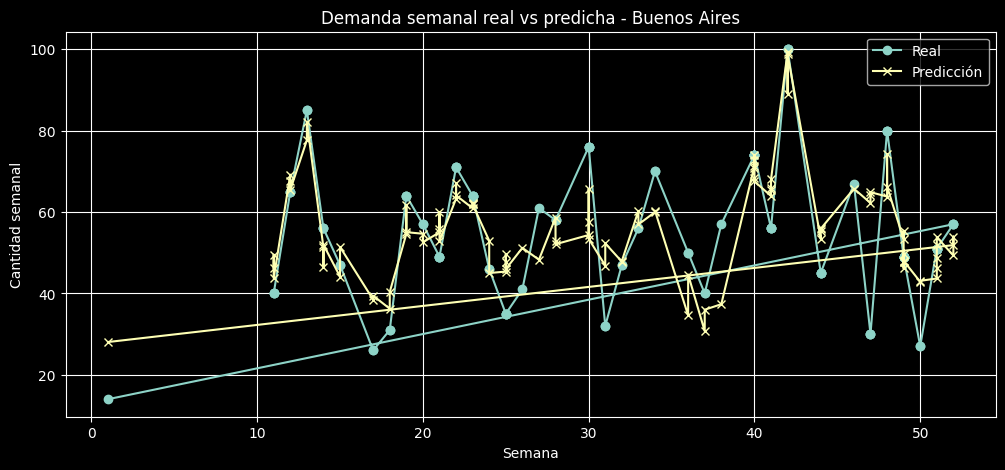

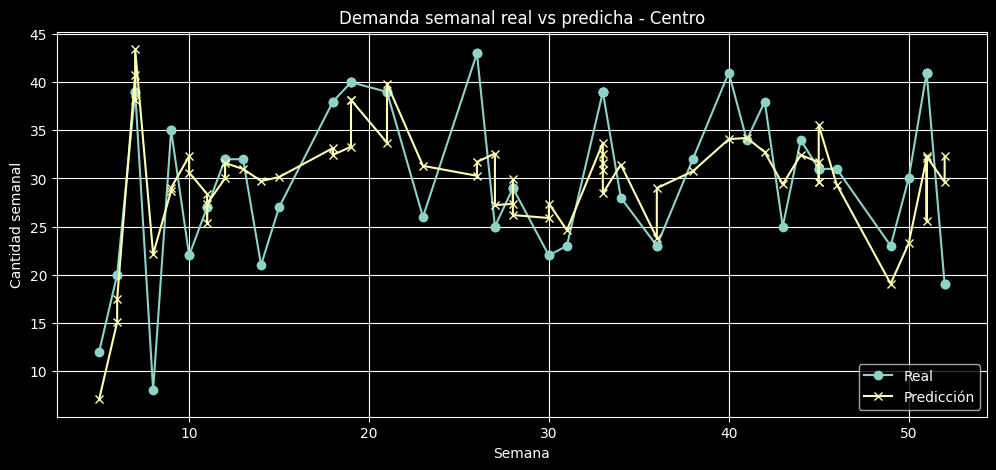

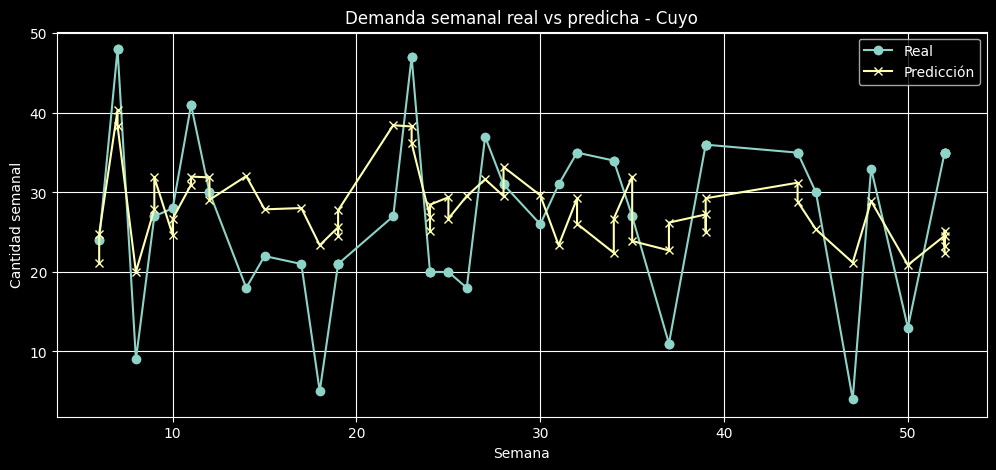

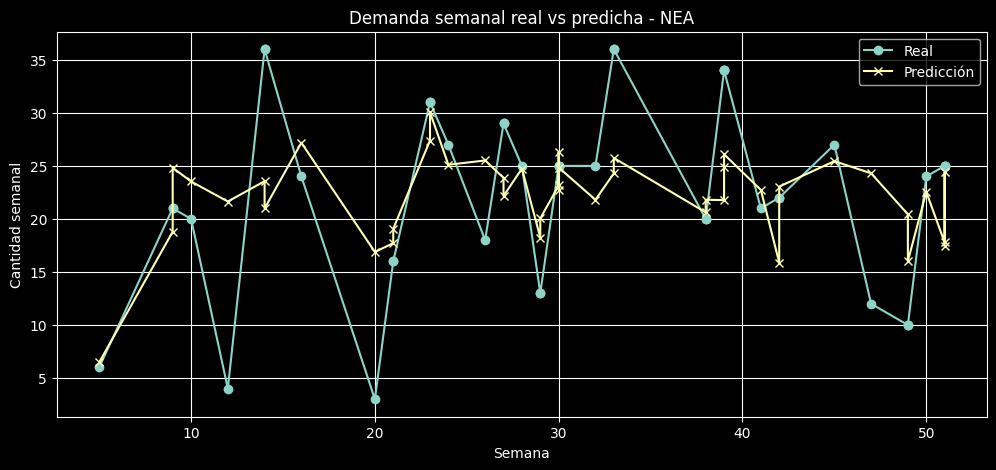

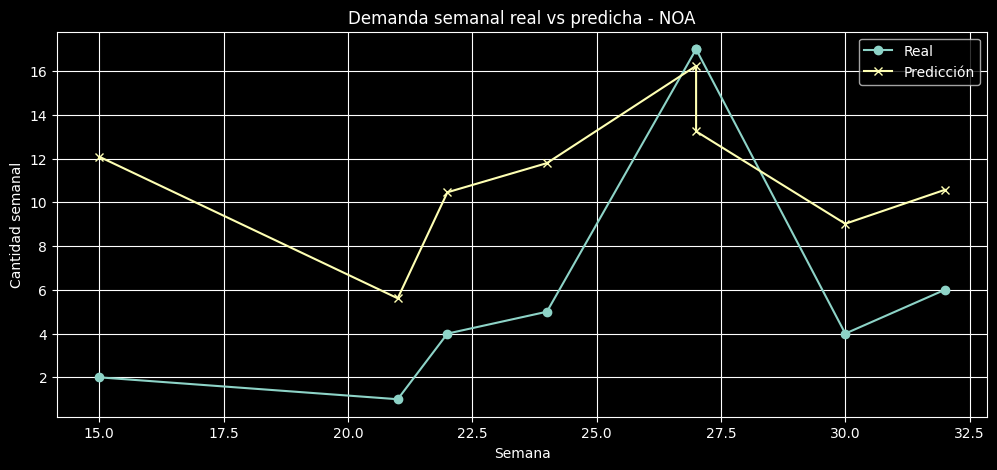

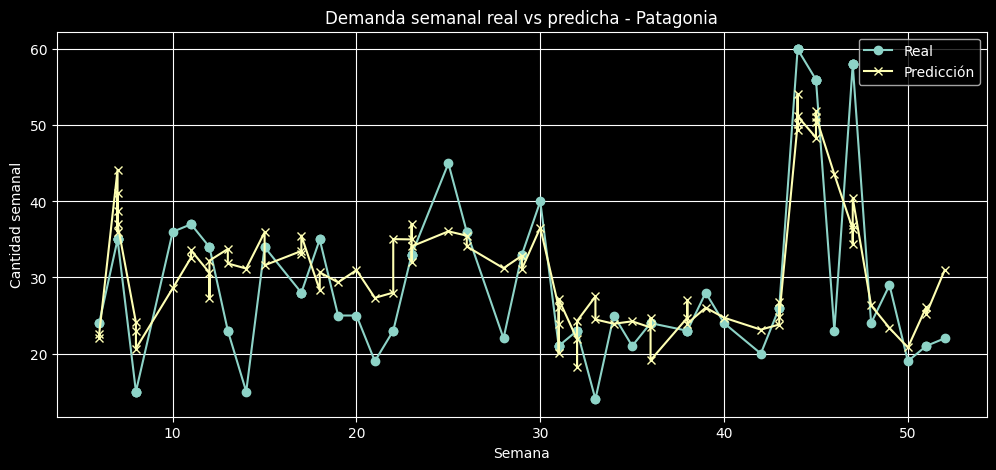

In [65]:
# Visualización de resultados por semana prediccion vs real por región
y_test_plot = y_test.reset_index(drop=True)
y_pred_plot = pd.Series(y_pred, name='Predicción')

# Crear un DataFrame para comparar real vs predicción
resultados = pd.DataFrame({
    'Semana': df_numeric.iloc[test_index]['semana'].reset_index(drop=True),
    'Region': df.iloc[test_index]['Region'].reset_index(drop=True),
    'Real': y_test_plot,
    'Predicción': y_pred_plot
})

# Graficar por región
for region in resultados['Region'].unique():
    datos_region = resultados[resultados['Region'] == region]
    plt.figure(figsize=(12, 5))
    plt.plot(datos_region['Semana'], datos_region['Real'], marker='o', label='Real')
    plt.plot(datos_region['Semana'], datos_region['Predicción'], marker='x', label='Predicción')
    plt.title(f'Demanda semanal real vs predicha - {region}')
    plt.xlabel('Semana')
    plt.ylabel('Cantidad semanal')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Prophet model for overall demand